In [1]:
pip install jax jaxlib


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/timesfm_venv/lib/python3.11/site-packages', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [5]:
from data.snp500 import snp500_daily

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm
from utils.metrics import calculate_metrics

# Constants - ensuring context window is multiple of 32 as required
CONTEXT_WINDOW = 320  # Must be multiple of 32 for TimesFM
FORECAST_STEPS = 128
PREDICTION_LENGTH = 1

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps", 
        per_core_batch_size=32,
        horizon_len=FORECAST_STEPS,
        num_layers=50,  # Required for 500m model
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

def generate_single_forecast(context_data):
    """Generate single-step forecast with TimesFM"""
    # Ensure data is 1D
    context = np.asarray(context_data).flatten()
    
    # Generate forecast
    point_forecast, quantile_forecast = tfm.forecast(
        [context],  # List of series
        freq=[0],   # 0 for daily data
    )
    
    # Extract forecasts
    median = point_forecast[0]  # First element since we only have one series
    quantiles = quantile_forecast[0]  # First element for our single series
    
    # Extract quantiles (10th and 90th percentiles)
    low = quantiles[1]    # 10th percentile
    high = quantiles[8]   # 90th percentile
    
    # Take only first value for single-step forecast
    return low[0], median[0], high[0]

def generate_sliding_window_forecasts(data, start_idx):
    """Sliding window implementation for TimesFM"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        context_start = current_idx - CONTEXT_WINDOW
        
        # Get context window
        context_data = data['Close'].iloc[context_start:current_idx].to_numpy()
        
        # Validate dimensions
        if len(context_data) != CONTEXT_WINDOW:
            raise ValueError(f"Invalid context window size: {len(context_data)}")
        
        # Generate forecast
        low, median, high = generate_single_forecast(context_data)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method="recursive"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS + 1]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - Chronos')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def run_experiment(data, target_date):
    """Run forecasting experiment"""
    # Convert target date to timestamp
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    # Validate sufficient history
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Generate forecasts
    forecasts = generate_sliding_window_forecasts(data, start_idx)
    
    # Calculate metrics
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    
    print("\nTimesFM Sliding Window Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")  

    # Plot results
    plot_forecasts(data, start_idx, forecasts)
    
    return forecasts, metrics

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 44150.57it/s]



TimesFM Sliding Window Forecast Metrics:
MAE: 101.7521
MSE: 14798.5336
RMSE: 121.6492
MAPE: 2.2292
SMAPE: 2.2648
MASE: None


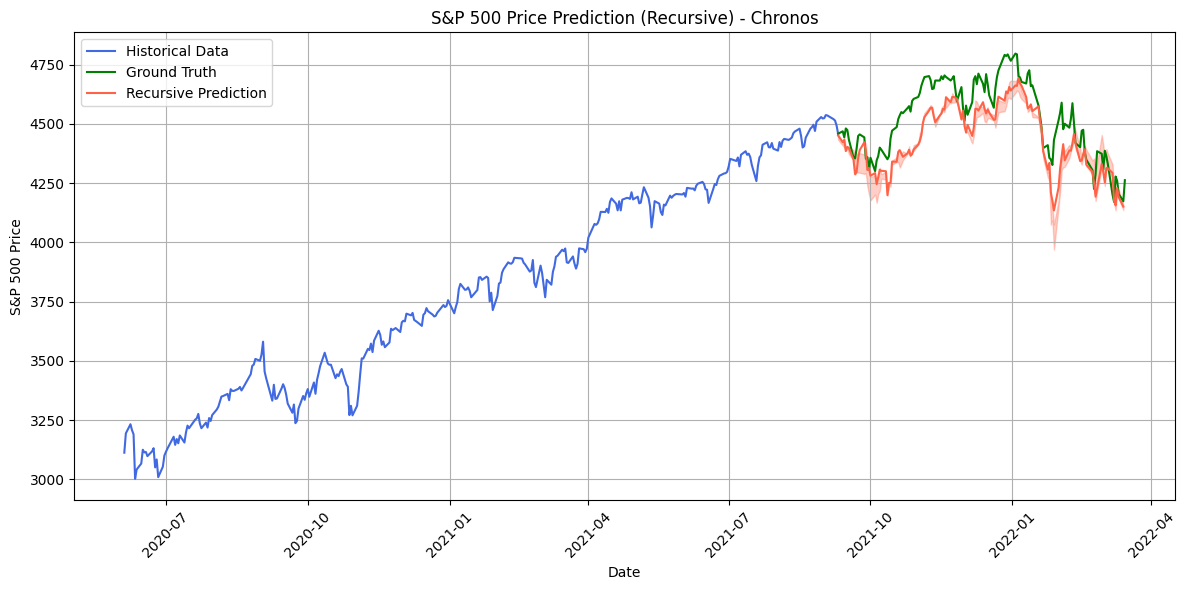

In [21]:
from data.snp500 import snp500_daily

sp500_d = snp500_daily

target_date = '2021-09-09'
forecasts, metrics = run_experiment(sp500_d, target_date)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 24013.19it/s]



TimesFM Recursive Forecast Metrics:
MAE: 19090.3283
MSE: 889446576.8092
RMSE: 29823.5909
MAPE: 421.6531
SMAPE: 142.7337
MASE: N/A


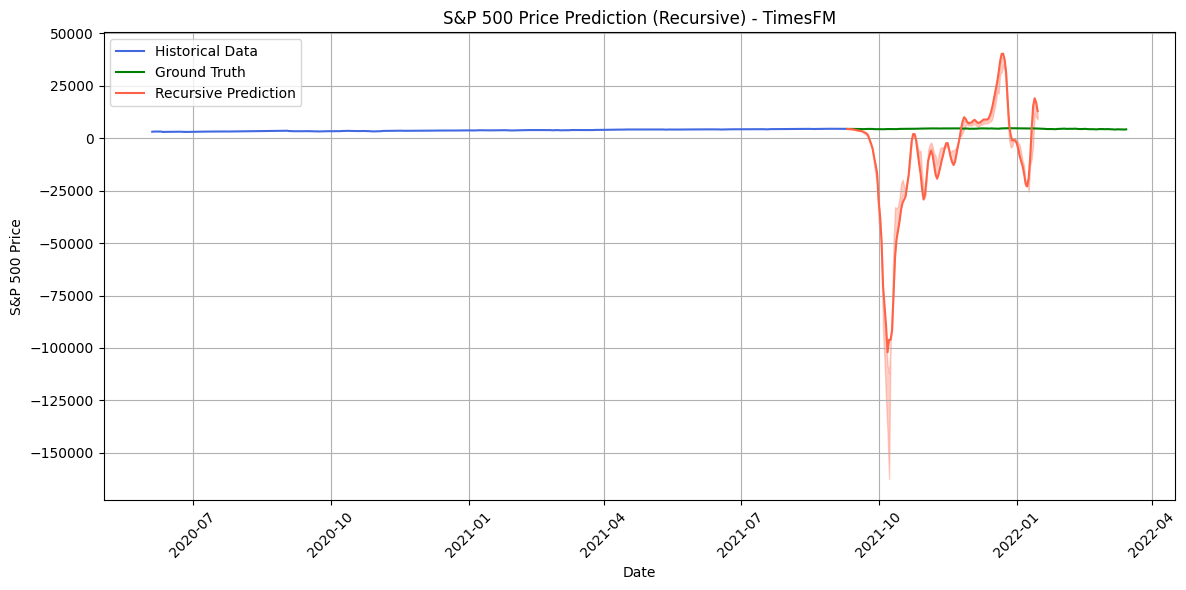

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm
from utils.metrics import calculate_metrics

# Constants - ensuring context window is multiple of 32 as required
CONTEXT_WINDOW = 320  # Must be multiple of 32 for TimesFM
FORECAST_STEPS = 128
PREDICTION_LENGTH = 1

# Initialize TimesFM
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=FORECAST_STEPS,
        num_layers=50,
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

def generate_single_forecast(context_data):
    """Generate single-step forecast with TimesFM"""
    # Ensure data is 1D
    context = np.asarray(context_data).flatten()
    
    # Generate forecast
    point_forecast, quantile_forecast = tfm.forecast(
        [context],  # List of series
        freq=[0],   # 0 for daily data
    )
    
    # Extract forecasts
    median = point_forecast[0]  # First element since we only have one series
    quantiles = quantile_forecast[0]  # First element for our single series
    
    # Extract quantiles (10th and 90th percentiles)
    low = quantiles[1]    # 10th percentile
    high = quantiles[8]   # 90th percentile
    
    # Take only first value for single-step forecast
    return low[0], median[0], high[0]

def generate_recursive_forecasts(data, start_idx):
    """Recursive forecasting implementation for TimesFM"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    # Initialize with actual historical data
    context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
    
    # Calculate all forecast dates upfront
    forecast_dates = pd.date_range(
        start=data['Date'].iloc[start_idx],
        periods=FORECAST_STEPS,
        freq='D'
    )
    
    for i in range(FORECAST_STEPS):
        # Generate forecast
        low, median, high = generate_single_forecast(context_data)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(forecast_dates[i])
        
        # Update context window: remove oldest value, add prediction
        context_data = np.append(context_data[1:], median)
        
        # Validation checks
        assert len(context_data) == CONTEXT_WINDOW, "Context window size changed"
        assert not np.isnan(median), "NaN value in prediction"
    
    return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method="recursive"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS + 1]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - TimesFM')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_recursive_experiment(data, target_date):
    """Run forecasting experiment"""
    # Convert target date to timestamp
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    # Validate sufficient history
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Generate forecasts
    forecasts = generate_recursive_forecasts(data, start_idx)
    
    # Calculate metrics
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    
    if metrics:  # Only print if metrics were successfully calculated
        print("\nTimesFM Recursive Forecast Metrics:")
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")
            else:
                print(f"{metric_name}: N/A")
    
    # Plot results
    plot_forecasts(data, start_idx, forecasts)
    
    return forecasts, metrics

from data.snp500 import snp500_daily

sp500_d = snp500_daily

target_date = '2021-09-09'
forecasts, metrics = run_recursive_experiment(sp500_d, target_date)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 66930.38it/s]


ValueError: 'x' has size 128, but 'y1' has an unequal size of 10

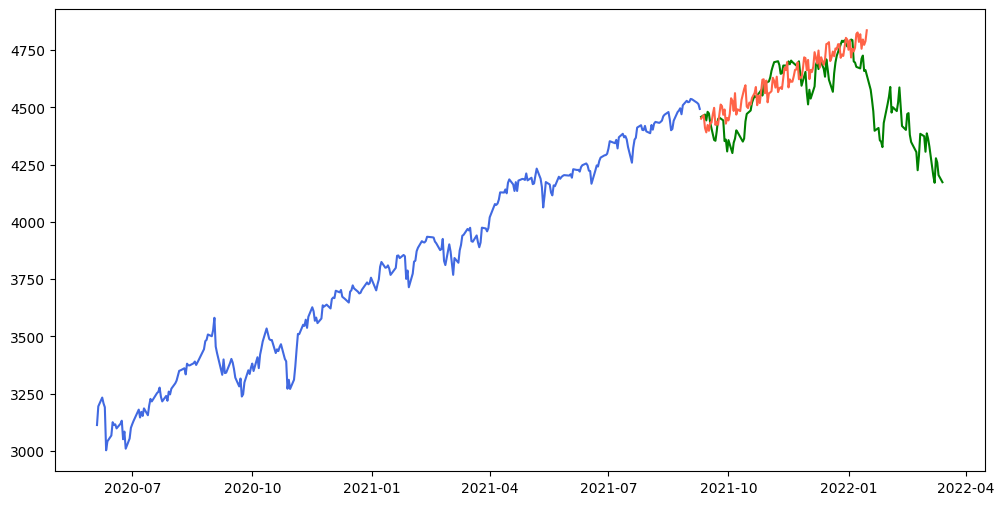

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm
from sklearn.preprocessing import StandardScaler

# Constants
CONTEXT_WINDOW = 320  # Must be multiple of 32 for TimesFM
FORECAST_STEPS = 128
PREDICTION_LENGTH = 1

# Initialize TimesFM
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=FORECAST_STEPS,  # Changed to match FORECAST_STEPS
        num_layers=50,
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_recursive_forecasts(self, data, start_idx):
        """Recursive forecasting implementation"""
        all_forecasts = {
            'median': np.zeros(FORECAST_STEPS),
            'low': np.zeros(FORECAST_STEPS),
            'high': np.zeros(FORECAST_STEPS),
            'dates': []
        }
        
        # Get initial context window
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
        
        # Fit scaler on context data
        self.scaler.fit(context_data.reshape(-1, 1))
        
        # Scale context data
        scaled_context = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        # Generate the full sequence forecast at once
        point_forecast, quantile_forecast = tfm.forecast(
            [scaled_context],
            freq=[0],  # daily data
        )
        
        # Get full sequence predictions
        median_scaled = point_forecast[0]  # shape: [forecast_steps]
        low_scaled = quantile_forecast[0][1]  # 10th percentile
        high_scaled = quantile_forecast[0][8]  # 90th percentile
        
        # Inverse transform predictions
        all_forecasts['median'] = self.scaler.inverse_transform(
            median_scaled.reshape(-1, 1)).flatten()
        all_forecasts['low'] = self.scaler.inverse_transform(
            low_scaled.reshape(-1, 1)).flatten()
        all_forecasts['high'] = self.scaler.inverse_transform(
            high_scaled.reshape(-1, 1)).flatten()
        
        # Calculate forecast dates
        all_forecasts['dates'] = pd.date_range(
            start=data['Date'].iloc[start_idx],
            periods=FORECAST_STEPS,
            freq='D'
        )
        
        return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method="recursive"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], 
                     forecasts['low'], 
                     forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - TimesFM')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_recursive_experiment(data, target_date):
    """Run recursive forecasting experiment"""
    predictor = TimeSeriesPredictor()
    
    # Convert target date to timestamp
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    # Validate sufficient history
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Generate forecasts
    forecasts = predictor.generate_recursive_forecasts(data, start_idx)
    
    # Plot results
    plot_forecasts(data, start_idx, forecasts)
    
    return forecasts

# Run experiment
if __name__ == "__main__":
    from data.snp500 import snp500_daily
    
    sp500_d = snp500_daily
    target_date = '2021-09-09'
    forecasts = run_recursive_experiment(sp500_d, target_date)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 29959.31it/s]



TimesFM Sliding Window Forecast Metrics:
MAE: 88.5055
MSE: 10417.5663
RMSE: 102.0665
MAPE: 1.9379
SMAPE: 1.9626
MASE: N/A


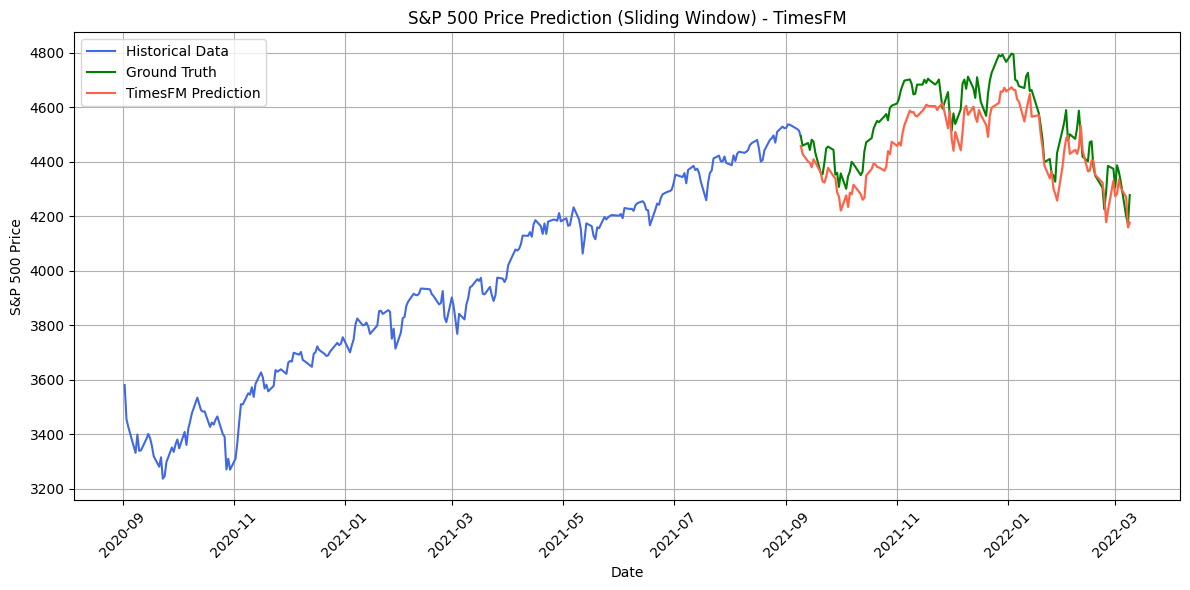

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timesfm

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics

# TimesFM-specific config
CONTEXT_WINDOW = 256  # Must be multiple of 32
FORECAST_STEPS = 126
PREDICTION_LENGTH = 1  # One-step forecasting

# Initialize TimesFM model
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=PREDICTION_LENGTH,
        num_layers=50,  # Required for 500m model
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

def generate_single_forecast(context_data):
    """Generate one-step forecast with TimesFM"""
    context = np.asarray(context_data).flatten().astype(np.float32)
    
    # TimesFM expects a list of series and frequencies
    point_forecast, quantile_forecast = tfm.forecast([context], freq=[0])
    
    # Extract the median from the point forecast
    median = point_forecast[0][0]
    
    # Check the shape of the quantile forecast.
    # If multiple quantiles are provided, use the 10th and 90th percentile.
    if quantile_forecast[0].shape[0] > 1:
        low = quantile_forecast[0][1][0]  # 10th percentile
        high = quantile_forecast[0][8][0]  # 90th percentile
    else:
        # Fallback: if only one quantile is available, use the median as a placeholder
        low = median
        high = median
    
    return low, median, high


def generate_sliding_window_forecasts(data, start_idx):
    """Sliding window implementation for TimesFM"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        context_start = current_idx - CONTEXT_WINDOW
        
        # Get and validate context window
        context_data = data['Close'].iloc[context_start:current_idx].values
        context_data = context_data.flatten()
        
        if len(context_data) != CONTEXT_WINDOW:
            raise ValueError(f"Invalid context window size: {len(context_data)}")
        
        # Generate forecast
        low, median, high = generate_single_forecast(context_data)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Visualization for TimesFM forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context (last CONTEXT_WINDOW points)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Forecasts
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label='TimesFM Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'],
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction (Sliding Window) - TimesFM')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Find start index with sufficient history
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Validate sufficient history
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")

# Generate forecasts
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, forecasts['median'])

print("\nTimesFM Sliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}" if value is not None else f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74898.29it/s]



TimesFM Multi-Step Forecast Metrics:
MAE: 146.9797
MSE: 38755.0387
RMSE: 196.8630
MAPE: 3.3034
SMAPE: 3.2264
MASE: N/A


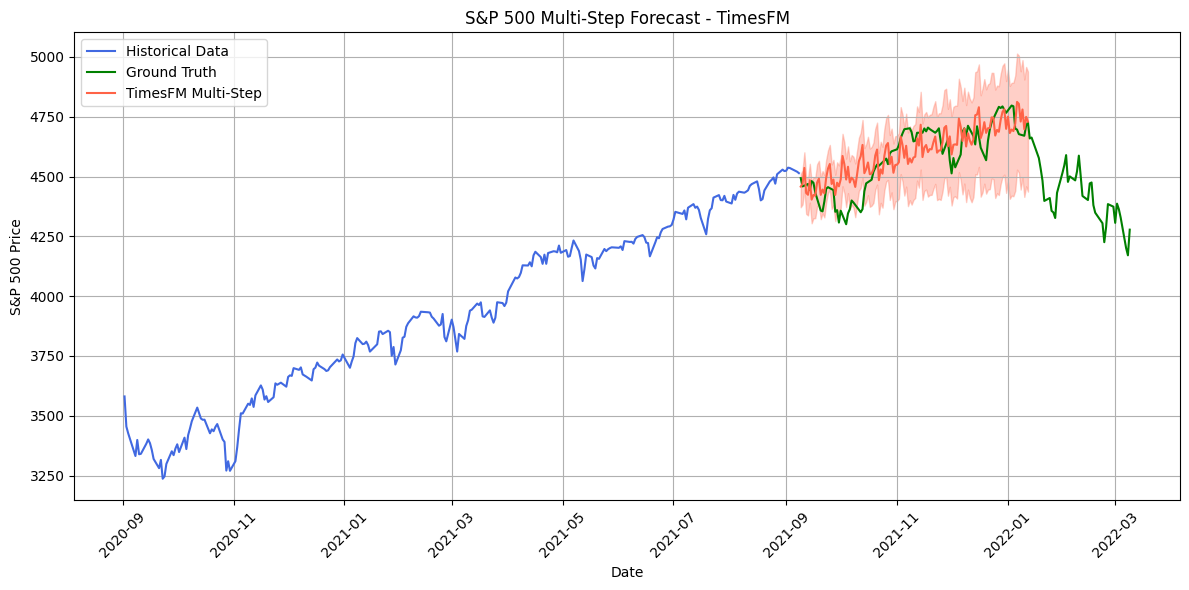

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timesfm

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics

# TimesFM-specific config
CONTEXT_WINDOW = 256  # Must be multiple of 32
FORECAST_STEPS = 126  # We want a 128-step direct forecast
# Note: horizon_len is set to FORECAST_STEPS here
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=FORECAST_STEPS,   # <--- 128-step horizon
        num_layers=50,
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

def generate_multi_step_forecast(context_data):
    """
    Generate a direct multi-step forecast with TimesFM.
    context_data: 1D array (length=CONTEXT_WINDOW) of historical values
    Returns arrays for low, median, and high predictions over FORECAST_STEPS steps.
    """
    # Ensure proper type/shape
    context = np.asarray(context_data).flatten().astype(np.float32)

    # TimesFM expects a list of series and frequencies
    # We'll get (point_forecast, quantile_forecast) with shape (1, FORECAST_STEPS, ...)
    point_forecast, quantile_forecast = tfm.forecast([context], freq=[0])

    # point_forecast[0] is shape (FORECAST_STEPS,).
    # quantile_forecast[0] might be shape (num_quantiles, FORECAST_STEPS).
    median_arr = point_forecast[0]  # shape: [FORECAST_STEPS]

    if quantile_forecast[0].shape[0] > 1:
        # e.g. the 10th and 90th percentiles for each time step
        low_arr = quantile_forecast[0][:, 1]   # CORRECT: yields shape (128,)
        high_arr = quantile_forecast[0][:, 8]  # CORRECT: yields shape (128,)
    else:
        # If only one quantile is present, fall back on the median
        low_arr = median_arr
        high_arr = median_arr

    return low_arr, median_arr, high_arr

def plot_multi_step_forecast(data, start_idx, forecast_arrays):
    """
    Plot a direct multi-step forecast from TimesFM.
    forecast_arrays = (low_arr, median_arr, high_arr)
    """
    low_arr, median_arr, high_arr = forecast_arrays

    # Build time axis for the forecast
    # We assume daily frequency for each forecast step
    forecast_dates = pd.date_range(
        start=data['Date'].iloc[start_idx],
        periods=FORECAST_STEPS,
        freq='D'
    )

    plt.figure(figsize=(12, 6))

    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW : start_idx]
    plt.plot(context_data['Date'], context_data['Close'],
             color='royalblue', label='Historical Data')

    # Plot ground truth (if available)
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'],
             color='green', label='Ground Truth')

    # Plot multi-step forecast
    plt.plot(forecast_dates, median_arr, color='tomato', label='TimesFM Multi-Step')
    plt.fill_between(forecast_dates, low_arr, high_arr,
                     color='tomato', alpha=0.3)

    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Multi‐Step Forecast - TimesFM')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------- Main Execution -------------------------

# 1. Load data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# 2. Find forecast start index
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# 3. Check we have enough context
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")

# 4. Get the context window array
context_data = sp500_d['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].values

# 5. Generate the multi-step forecast in one call
low_arr, median_arr, high_arr = generate_multi_step_forecast(context_data)

# 6. Evaluate metrics
actual_values = sp500_d['Close'].iloc[start_idx : start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, median_arr)
print("\nTimesFM Multi-Step Forecast Metrics:")
for metric_name, val in metrics.items():
    print(f"{metric_name}: {val:.4f}" if val is not None else f"{metric_name}: N/A")

# 7. Plot the forecast
plot_multi_step_forecast(sp500_d, start_idx, (low_arr, median_arr, high_arr))


TimesFM Recursive Forecast Metrics (Scaled + Reindexed):
MAE: 32979.4564
MSE: 2514903519.7447
RMSE: 50148.8137
MAPE: 731.3854
SMAPE: 134.4715
MASE: N/A


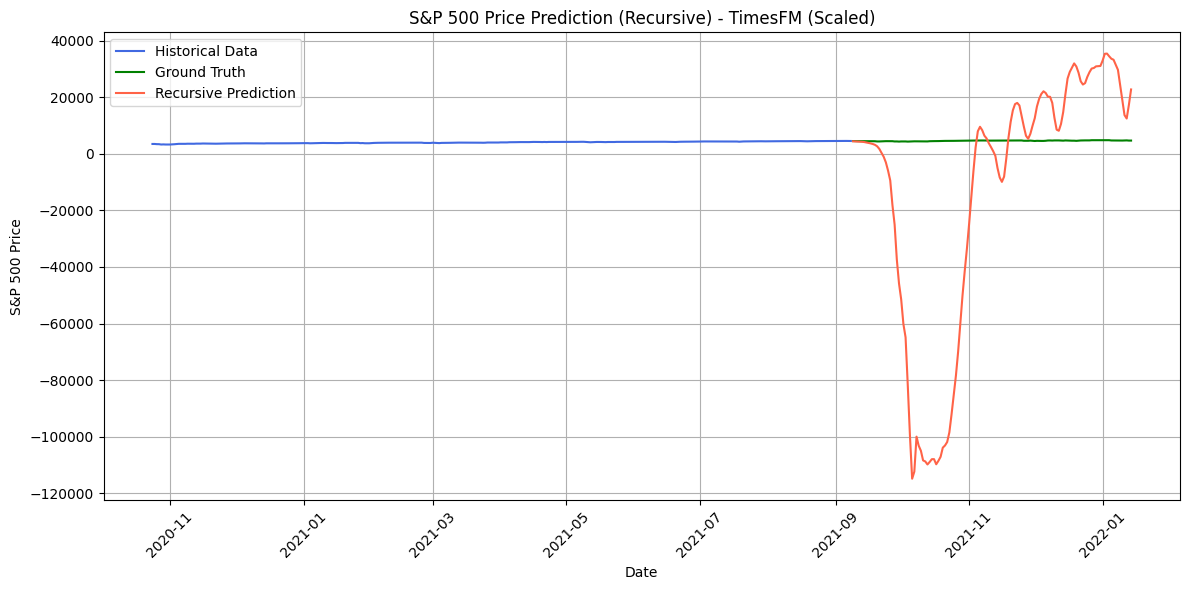

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import timesfm

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics

# ============ TimesFM Configuration ============
CONTEXT_WINDOW = 320   # Must be multiple of 32
FORECAST_STEPS = 128
PREDICTION_LENGTH = 1  # One-step forecasting

# Initialize TimesFM model
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=PREDICTION_LENGTH,
        num_layers=50,  # Required for 500m model
        context_len=CONTEXT_WINDOW,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

def generate_single_forecast(context_data_scaled):
    """
    Generate a one-step forecast with TimesFM in *scaled* space.
    Returns the predicted (scaled) median for the next step.
    """
    context = np.asarray(context_data_scaled).flatten().astype(np.float32)
    point_forecast, _quantile_forecast = tfm.forecast([context], freq=[0])
    
    # Extract the median from point_forecast (still in scaled space)
    median_scaled = point_forecast[0][0]
    return median_scaled

def generate_recursive_forecasts(data, start_idx, scaler):
    """
    Autoregressive one-step-at-a-time forecasting, using scaled data for the model.
    Then invert scale for final predictions.
    
    * data: DataFrame with columns ["Date", "Close", "CloseScaled"]
    * start_idx: index at which to begin the forecast
    * scaler: StandardScaler used to transform 'Close'
    """
    all_forecasts = {
        'median': [],
        'dates': []
    }
    
    # 1) Extract the scaled context for the last CONTEXT_WINDOW points before start_idx
    context_data_scaled = data["CloseScaled"].iloc[start_idx - CONTEXT_WINDOW : start_idx].values
    
    # 2) Loop FORECAST_STEPS times, each time predicting one future step
    for i in range(FORECAST_STEPS):
        # Generate the scaled forecast
        median_scaled = generate_single_forecast(context_data_scaled)
        
        # Convert forecast back to original scale
        median_unscaled = (median_scaled * scaler.scale_[0]) + scaler.mean_[0]
        
        # Date alignment
        current_forecast_date = data["Date"].iloc[start_idx + i]
        
        # Store unscaled forecast
        all_forecasts['median'].append(median_unscaled)
        all_forecasts['dates'].append(current_forecast_date)
        
        # Remove oldest from context, append newly predicted *scaled* median
        context_data_scaled = np.append(context_data_scaled[1:], median_scaled)
    
    return all_forecasts

def plot_recursive_forecasts(data, start_idx, forecasts):
    """
    Plot the historical data, ground truth, and the recursive forecasts (unscaled).
    """
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW : start_idx]
    plt.plot(context_data["Date"], context_data["Close"],
             color="royalblue", label="Historical Data")
    
    # Plot ground truth
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    plt.plot(actual_data["Date"], actual_data["Close"],
             color="green", label="Ground Truth")
    
    # Plot recursive predictions (already unscaled)
    plt.plot(forecasts["dates"], forecasts["median"],
             color="tomato", label="Recursive Prediction")
    
    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title("S&P 500 Price Prediction (Recursive) - TimesFM (Scaled)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============ Main Execution ============
if __name__ == "__main__":
    # 1) Load raw S&P 500 data
    sp500_raw = snp500_daily.reset_index()[["Date", "Close"]]
    sp500_raw["Date"] = pd.to_datetime(sp500_raw["Date"])
    
    # 2) Reindex to daily frequency (including weekends), forward fill missing days
    #    so TimesFM sees a true daily sequence
    sp500_daily_ff = (
        sp500_raw
        .set_index("Date")
        .resample("D")     # daily frequency
        .ffill()           # forward fill missing days
        .reset_index()
    )
    
    # 3) Fit StandardScaler on the reindexed data
    scaler = StandardScaler()
    sp500_daily_ff["CloseScaled"] = scaler.fit_transform(sp500_daily_ff[["Close"]])
    
    # 4) Select your target date and find start_idx in the *reindexed* data
    target_date = pd.Timestamp("2021-09-09")
    # Ensure the data is sorted by date
    sp500_daily_ff.sort_values("Date", inplace=True)
    sp500_daily_ff.reset_index(drop=True, inplace=True)
    
    # Now find the position where 'Date' <= target_date
    valid_indices = sp500_daily_ff[sp500_daily_ff["Date"] <= target_date].index
    if len(valid_indices) == 0:
        raise ValueError("No data available on or before target_date")
    start_idx = valid_indices[-1]
    
    # 5) Validate we have enough history for CONTEXT_WINDOW
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history before {target_date}")
    
    # 6) Generate recursive forecasts
    forecasts = generate_recursive_forecasts(sp500_daily_ff, start_idx, scaler)
    
    # 7) Evaluate metrics (in unscaled domain)
    actual_values = sp500_daily_ff["Close"].iloc[start_idx : start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, forecasts["median"])
    
    print("\nTimesFM Recursive Forecast Metrics (Scaled + Reindexed):")
    for metric_name, val in metrics.items():
        print(f"{metric_name}: {val:.4f}" if val is not None else f"{metric_name}: N/A")
    
    # 8) Plot results
    plot_recursive_forecasts(sp500_daily_ff, start_idx, forecasts)
